In [142]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)


def img2pose(x):
    return Path(f"{str(x)[:-7]}pose.txt")


cal = np.genfromtxt(path / "01" / "rgb.cal", skip_footer=6)


def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0] / ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1] / ctr[2] + cal[1][2]
    return tensor([c1, c2])


biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name == "13"),
    batch_tfms=[
        *aug_transforms(size=(240, 320)),
        Normalize.from_stats(*imagenet_stats),
    ],
)

In [144]:
# # xforms = Resi Normalize.from_stats
# xforms = [, Normalize.from_stats(*imagenet_stats), ]

# transforms.Compose(
#         [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),]
#     )

xforms = transforms.Compose([Resize((240, 320), method='bilinear'), transforms.ToTensor(), Normalize.from_stats(*imagenet_stats)])

In [3]:
dls = biwi.dataloaders(path)

learn = cnn_learner(dls, resnet18, y_range=(-1, 1))

lr = 1e-2
learn.fine_tune(3, lr)
learn.export()

epoch,train_loss,valid_loss,time
0,0.047956,0.012584,00:31


epoch,train_loss,valid_loss,time
0,0.007785,0.002163,00:36
1,0.003726,0.000515,00:36
2,0.001440,0.000159,00:36


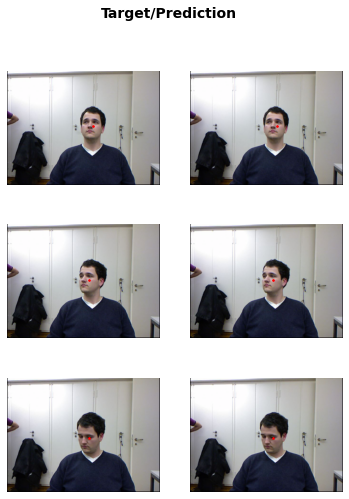

In [4]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

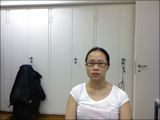

In [138]:
img_path = path / "03" / "frame_00003_rgb.jpg"
im = PILImage.create(img_path)
im.to_thumb(160)

In [139]:
im.shape

(480, 640)

In [145]:
im_xformed = xforms(im)

In [146]:
im_xformed.shape, im_xformed.min()

(torch.Size([3, 240, 320]), tensor(0.))

In [148]:
prediction = learn.predict(im)
actual = get_ctr(img_path)

prediction, actual

((TensorPoint([[197.4389, 129.9744]]),
  tensor([0.2340, 0.0831]),
  tensor([0.2340, 0.0831])),
 tensor([391.9055, 260.5018]))

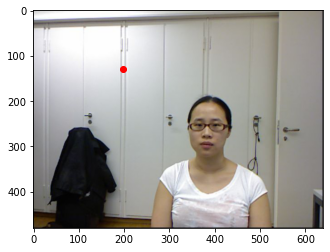

In [119]:
x, y = prediction[0][0]
plt.imshow(im)
plt.plot(x, y, 'ro')

In [120]:
model_path = Path()
learn_inf = load_learner(model_path / "export.pkl")

img_path = path / "03" / "frame_00003_rgb.jpg"
prediction = learn_inf.predict(img_path)

print(prediction)
print(get_ctr(img_path))

(TensorPoint([[197.4389, 129.9745]]), tensor([0.2340, 0.0831]), tensor([0.2340, 0.0831]))
tensor([391.9055, 260.5018])


In [86]:
img = biwi.data.valid_ds[0][0]
learn.predict(img)

AttributeError: 'DataBlock' object has no attribute 'data'

In [150]:
dl = biwi.dataloaders(path)

In [232]:
x, y = dl.one_batch()

In [233]:
x.shape, y.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


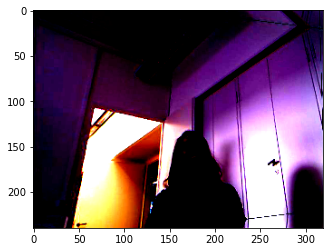

In [234]:
plt.imshow(x[0].cpu().permute(1, 2, 0).numpy())

In [235]:
x[0].permute(1, 2, 0).shape

torch.Size([240, 320, 3])

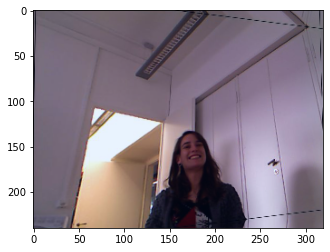

In [236]:
new_im = x[0].cpu().permute(1, 2, 0).numpy()
mn, mx = new_im.min(), new_im.max()

new_im += abs(new_im.min())
new_im /= abs(new_im.max())
plt.imshow(new_im)

In [237]:
aug_transforms

<function fastai.vision.augment.aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0)>

In [238]:
learn.predict(x[0].cpu())

(TensorPoint([[165.6072, 129.5747]]),
 tensor([0.0350, 0.0798]),
 tensor([0.0350, 0.0798]))

In [239]:
y[0]

TensorPoint([[0.0556, 0.2527]], device='cuda:0')

In [240]:
yhat = learn.forward(x[0].unsqueeze(0))
yhat

tensor([[0.0451, 0.2539]], device='cuda:0', grad_fn=<AddBackward0>)

In [241]:
a, b = yhat.cpu().detach()[0]
a, b

(tensor(0.0451), tensor(0.2539))

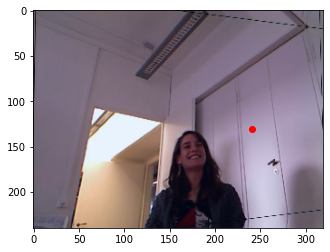

In [242]:
plt.imshow(new_im)
plt.plot(320*b + 320/2, 240*a + 240/2, 'ro')